<a href="https://colab.research.google.com/github/steflhermitte/EO-Notebooks/blob/master/RemoteSensing%2BBigData/RSBD_Notebook2_PythonMappinginGEE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src="https://raw.githubusercontent.com/mbakker7/exploratory_computing_with_python/master/tudelft_logo.png" width="200" align='right'>](https://www.tudelft.nl/citg/over-faculteit/afdelingen/geoscience-remote-sensing/staff/scientific-staff/dr-stef-lhermitte)


# Mapping with Python in GeeMap
Created by Stef Lhermitte (s.lhermitte at tudelft.nl / [@steflhermitte](https://twitter.com/StefLhermitte) | www.earthmapps.io)*

*with inspiration and fragments from:*

 *  [geemap](https://geemap.org/)


[![Twitter](https://img.shields.io/twitter/url/https/twitter.com/cloudposse.svg?style=social&label=%20%40steflhermitte)](https://twitter.com/steflhermitte)

## Before you start
Before starting this notebook make sure that you installed the necessary packages (see [Python installation example notebook](https://colab.research.google.com/drive/1MccJkybH3jEDeQ8GkU7NmtbXP8ZE4V5M?usp=sharing)). For your local computer, you only need to install the packages once and you won't need the next cell. For Colab, you need to run the following installation steps every time you start a new notebook and restart the environment afterwards.





In [6]:
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install git+https://github.com/SciTools/cartopy.git --no-binary cartopy
!apt-get -qq install python-cartopy python3-cartopy
!pip uninstall -y shapely    # cartopy and shapely aren't friends (early 2020)
!pip install shapely --no-binary shapely
!pip install geemap

For colab users: don't forget to restart your runtime after installation to avoid problems with matplotlib.

## Geemap

In this notebook, we are going to create maps using geemap as interface. geemap is a Python package for interactive mapping with Google Earth Engine (GEE), which is a cloud computing platform with a multi-petabyte catalog of satellite imagery and geospatial datasets. During the past few years, GEE has become very popular in the geospatial community and it has empowered numerous environmental applications at local, regional, and global scales. GEE provides both JavaScript and Python APIs for making computational requests to the Earth Engine servers. Compared with the comprehensive documentation and interactive IDE (i.e., GEE JavaScript Code Editor) of the GEE JavaScript API, the GEE Python API has relatively little documentation and limited functionality for visualizing results interactively. The geemap Python package was created to fill this gap. It is built upon ipyleaflet and ipywidgets, and enables users to analyze and visualize Earth Engine datasets interactively within a Jupyter-based environment. The ipyleaflet or folium interface allows moreover to visualize geospatial data dynamically, allowing to zoom/pan etc.

For video tutorials and notebook examples, please visit the [examples](https://github.com/giswqs/geemap/tree/master/examples) page. For complete documentation on geemap modules and methods, please visit the [API Reference](https://geemap.org/geemap/).

For example, by running the following cell we will initiate an interactive ipyleaflet map.

In [36]:
import ee
import geemap

In [21]:
Map = geemap.Map()
Map

At the moment this Map is still empty as we did not add any data to it, but we can do that easily using different approaches. 


### Basemaps 
For example we can add different basemaps (see https://geemap.org/basemaps/), which we can toggle in the right corner using the icon 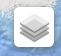 

In [22]:
Map = geemap.Map()
Map.add_basemap('SATELLITE')
Map.add_basemap('ROADMAP')
Map.add_basemap('Esri Ocean')
Map.add_basemap('Esri National Geographic')
Map

### WMS
Or we can add WMS and XYZ tile layers:

In [23]:
Map = geemap.Map()
# Add XYZ tiles
url = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}'
Map.add_tile_layer(url, name='Google Map', attribution='Google')
# Add WMS tiles
naip_url = 'https://services.nationalmap.gov/arcgis/services/USGSNAIPImagery/ImageServer/WMSServer?'
Map.add_wms_layer(url=naip_url, layers='0', name='NAIP Imagery', format='image/png', shown=True)
# For example last weeks example MODIS example
wv_url = 'https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi'
Map.add_wms_layer(url=wv_url,layers='VIIRS_SNPP_CorrectedReflectance_TrueColor',time='2021-04-01', name='MODIS')
# Or the PDOK imagery
pd_url = 'https://service.pdok.nl/hwh/luchtfotorgb/wms/v1_0'
Map.add_wms_layer(url=pd_url,layers='Actueel_ortho25',name='PDOK',shown=False)
Map

### GEE data
Or we can add GEE data ranging from images/image collections to geometries/features/feature collections.



#### Images vs. image collections
When processing data it is important to understand the difference between images and image collections. 
[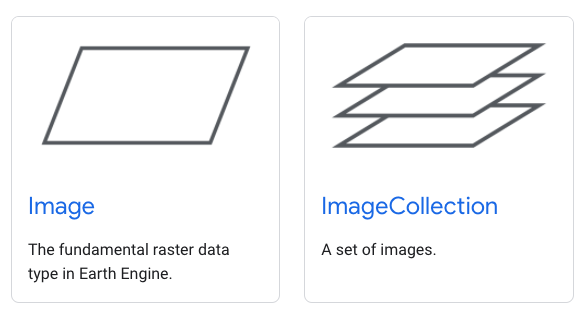](https://developers.google.com/earth-engine/guides/objects_methods_overview)

Images are individual rasters composed of one or more bands and each band has its own name, data type, scale, mask and projection. Each image has metadata stored as a set of properties. Images can be loaded by pasting an Earth Engine asset ID into the `ee.Image()` constructor. You can find image IDs in the [data catalog](https://developers.google.com/earth-engine/datasets). For example, to load the USGS SRTM:

In [24]:
# Define Earth Engine dataset
image = ee.Image('USGS/SRTMGL1_003')

Subsequently, we can add it to our Map by defining some visualization parameters. Here we are going to define only the min/max value to visualize, but you can find additional visualisation parameters [here](https://developers.google.com/earth-engine/guides/image_visualization).

In [25]:
# Set visualization parameters.
vis_params = {
  'min': 0,
  'max': 4000}

# Create Map
Map = geemap.Map()

# Add Earth Engine layers to Map
Map.addLayer(image, {'min':0,'max':4000}}, 'SRTM')

# Show map
Map

An ImageCollection is a stack or sequence of images. For example, it can be the entire [Sentinel-2 surface reflection collection]('https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR') which contains all Sentinel-2 surface reflectance images over the Earth.

An ImageCollection can be loaded by pasting an Earth Engine asset ID into the `ee.ImageCollection` constructor. You can find ImageCollection IDs in the [data catalog](https://developers.google.com/earth-engine/datasets). 

In [26]:
sentinelCollection = ee.ImageCollection('COPERNICUS/S2_SR');

This collection contains every Sentinel-2 image in the public catalog. There are a lot. Usually you want to filter the collection before. Filtering can occur based on:
 * region of interest / bounds:  to only get images that contain a certain area. Later we will see how to define such an area
 * date: to only get images from a certain date range
 * metadata: to only get images that fulfill a certain metadata requirement (e.g. only images with less than x% cloud cover). To get an idea of the potential metadata, I recommend to have a look at the data catalog -> `Image Properties` for each collection (e.g. for S2: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR)

In [27]:
S2 = (ee.ImageCollection('COPERNICUS/S2_SR')
         .filterBounds(ee.Geometry.Point(4, 52))
         .filterDate('2019-01-01', '2019-12-31')
         .filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than',20))

The standard way to get an image out of a collection is to reduce the collection. For example, we can sort based on a metadata field and subsequently get the first image. Notice in the following example that the image appears very dark as the min/max values are 0/10000 (corresponding to relfectance values of 0/1; see scale parameter in [data catalog](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR#bands)), but changing the max-value to a lower valuye will make it clearer.

In [29]:
# Sort and get first image
S2_im = S2.sort('CLOUDY_PIXEL_PERCENTAGE').first()
# Define vis parameters
S2_vis = {'bands':['B4','B3','B2'],
          'min':0,
          'max':5000}
# Initialize Map
Map = geemap.Map()
# Add image
Map.addLayer(S2_im,S2_vis,'S2 first image')
# Zoom map on image on scale level 10
Map.center_object(S2_im,10)

Map

#### Geometries in GEE
We can also define geometries in GEE as Earth Engine handles vector data with the Geometry type. GEE support points and polygons but in this example notebook we are going to limit ourselves to points and rectangles. By default these are defined in `EPSG:4326` so lat/lon coordinates. Subsequently we can use these geometries to filter our data or define an output geometry when exporting

In [30]:
# Point based on lon/lat
point = ee.Geometry.Point([1.5, 1.5])
# Rectangle based on (minLon, minLat, maxLon, maxLat).
rectangle = ee.Geometry.Rectangle([4.30,51.95,4.39,52])
# rectangle = ee.Geometry.Rectangle([4.38,51.2,4.9,52])

## Cartoee
Geemap has also a sister package, cartoee, that builds upon cartopy to create static maps/figures. cartoee is a lightweight module to aid in creatig publication quality maps from Earth Engine processing results without having to download data. The cartoee package does this by requesting png images from EE results (which are usually good enough for visualization) and cartopy is used to create the plots. Utility functions are available to create plot aethetics such as gridlines or color bars.

First we need to load the package:

In [31]:
%pylab inline
# import the cartoee functionality from geemap
from geemap import cartoee
import cartopy.crs as ccrs
Map = geemap.Map()

Populating the interactive namespace from numpy and matplotlib


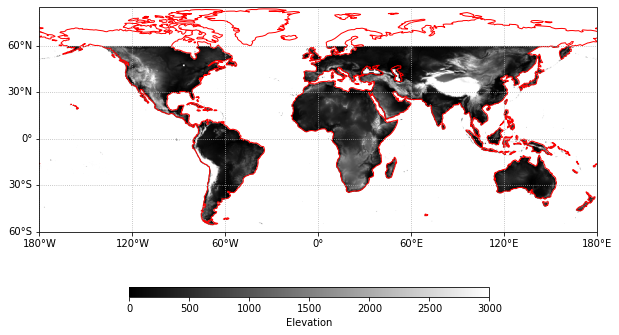

In [32]:
# get an image
srtm = ee.Image("CGIAR/SRTM90_V4")
region = [-180,-60,180,85] # define bounding box to request data
vis = {'min':0,'max':3000} # define visualization parameters for image
fig = plt.figure(figsize=(10,7))

# use cartoee to get a map
ax = cartoee.get_map(srtm,region=region,vis_params=vis)

# add a colorbar to the map using the visualization params we passed to the map
cartoee.add_colorbar(ax, vis, loc="bottom",label="Elevation",orientation="horizontal")

# add gridlines to the map at a specified interval
cartoee.add_gridlines(ax,interval=[60,30],linestyle=":")

# add coastlines using the cartopy api
ax.coastlines(color="red")

plt.show()

### Mapping with different projections
You can specify what ever projection is available within cartopy to display the results from Earth Engine. Here are a couple examples of global and regions maps again using the SRTM example. Please refer to the [cartopy projection documentation](https://scitools.org.uk/cartopy/docs/latest/crs/projections.html) for more examples with different projections.

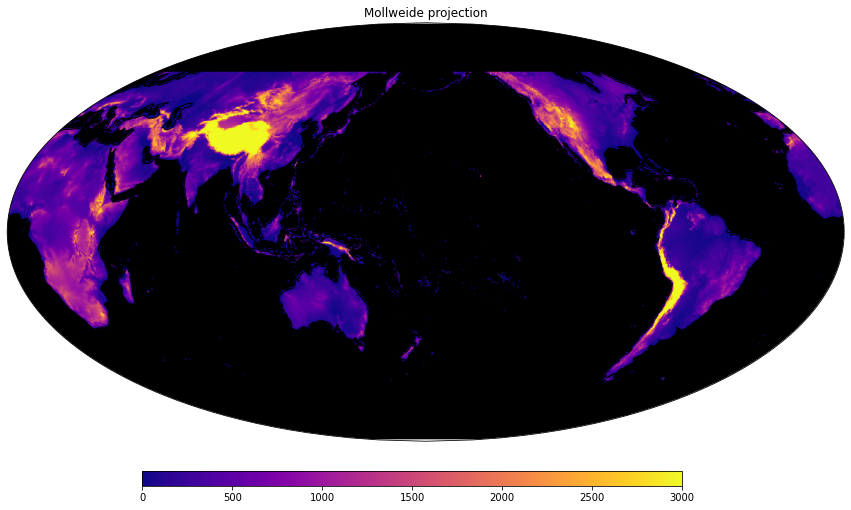

In [33]:
fig = plt.figure(figsize=(15,10))

# create a new Mollweide projection centered on the Pacific
projection = ccrs.Mollweide(central_longitude=-180)

# plot the result with cartoee using the Mollweide projection
ax = cartoee.get_map(srtm, vis_params=vis, region=bbox,
                cmap='plasma', proj=projection)
cb = cartoee.add_colorbar(ax,vis_params=vis, loc='bottom', cmap='plasma',
                    orientation='horizontal')

ax.set_title("Mollweide projection")

ax.coastlines()
plt.show()

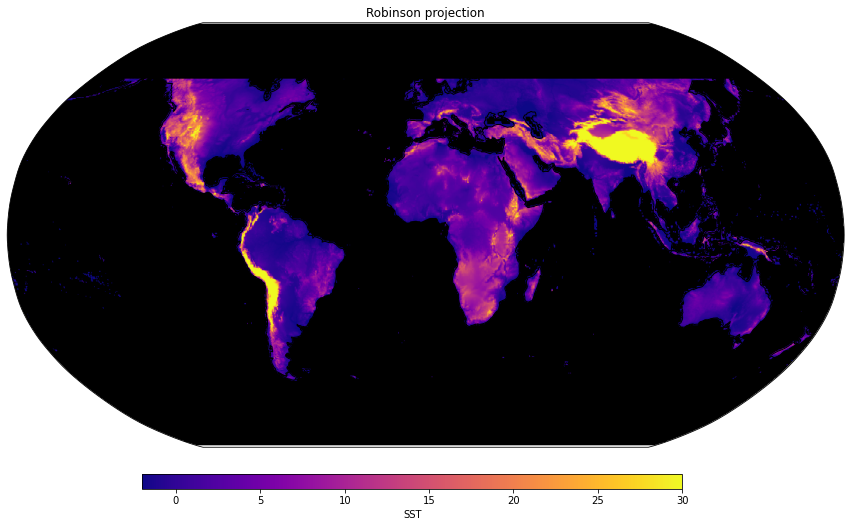

In [17]:
fig = plt.figure(figsize=(15,10))

# create a new Goode homolosine projection centered on the Pacific
projection = ccrs.Robinson(central_longitude=0)

# plot the result with cartoee using the Goode homolosine projection
ax = cartoee.get_map(srtm, vis_params=vis, region=bbox,
                cmap='plasma', proj=projection)
cb = cartoee.add_colorbar(ax, vis_params=visualization, loc='bottom', cmap='plasma',
                    orientation='horizontal')

ax.set_title("Robinson projection")

ax.coastlines()
plt.show()

### Warping artefacts
Often times global projections are not needed so we use specific projection for the map that provides the best view for the geographic region of interest. When we use these, sometimes image warping effects occur. This is because cartoee only requests data for region of interest and when mapping with cartopy the pixels get warped to fit the view extent as best as possible. Consider the following example where we want to map SST over the south pole:

In [34]:
# get an earth engine image of ocean data for Jan-Mar 2018
ocean = (
    ee.ImageCollection('NASA/OCEANDATA/MODIS-Terra/L3SMI')
    .filter(ee.Filter.date('2018-01-01', '2018-03-01'))
    .median()
    .select(["sst"], ["SST"])
)
# set parameters for plotting
# will plot the Sea Surface Temp with specific range and colormap
visualization = {'bands':"SST", 'min':-2, 'max':30}
# specify region to focus on
bbox = [-180, -88, 180, 88]

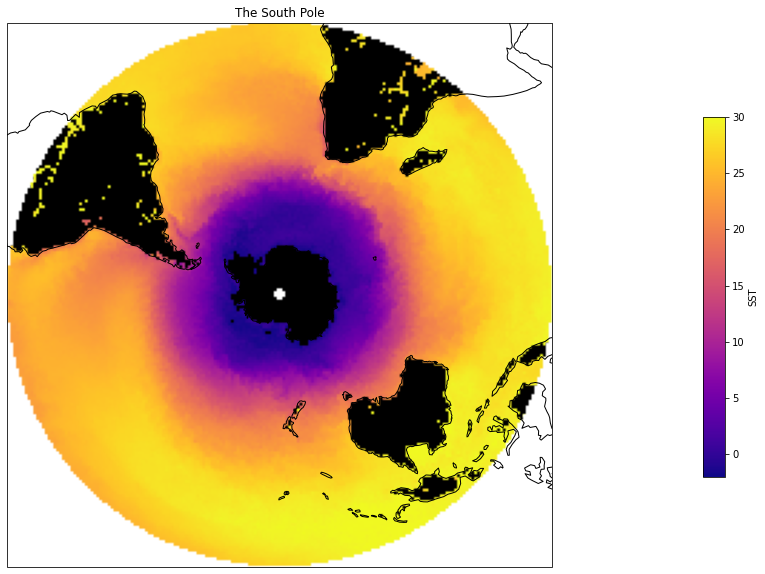

In [35]:
fig = plt.figure(figsize=(15, 10))

# Create a new region to focus on
spole = [-180, -88, 180,0]

projection = ccrs.SouthPolarStereo()

# plot the result with cartoee focusing on the south pole
ax = cartoee.get_map(ocean, cmap='plasma', vis_params=visualization, region=spole, proj=projection)
cb = cartoee.add_colorbar(ax, vis_params=visualization, loc='right', cmap='plasma')

# convert bbox coordinate from [W,S,E,N] to [W,E,S,N] as matplotlib expects
zoom_extent = cartoee.bbox_to_extent(spole)

# set the extent of the map to the zoom area
ax.set_extent(zoom_extent,ccrs.PlateCarree())

ax.coastlines()
ax.set_title('The South Pole')
plt.show()

As you can see from the result there are warping effects on the plotted image. There is really no way of getting around this (other than requesting a larger extent of data which may not always be the case).

So, what we can do is set the extent of the map to a more realistic view after plotting the image as in the following example:

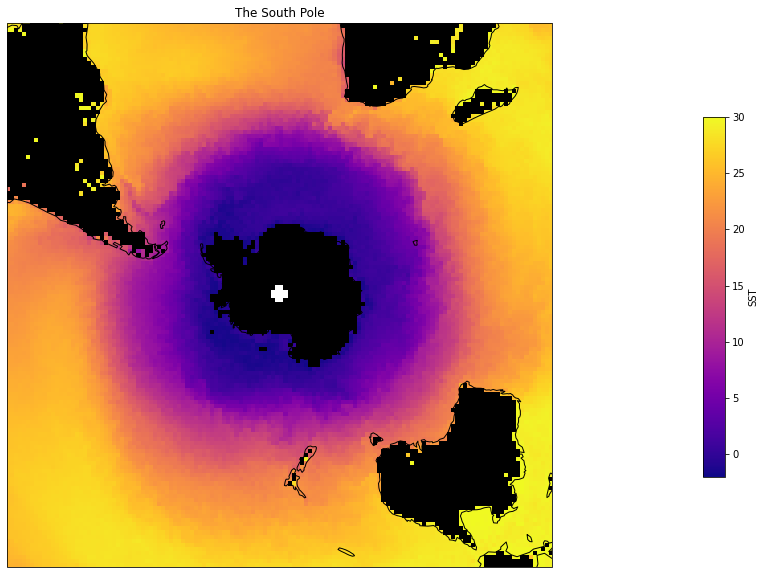

In [19]:
fig = plt.figure(figsize=(15,10))

# plot the result with cartoee focusing on the south pole
ax = cartoee.get_map(ocean, cmap='plasma', vis_params=visualization, region=spole, proj=projection)
cb = cartoee.add_colorbar(ax, vis_params=visualization, loc='right', cmap='plasma')

ax.coastlines()
ax.set_title('The South Pole')

# get bounding box coordinates of a zoom area
zoom = spole
zoom[-1] = -20

# convert bbox coordinate from [W,S,E,N] to [W,E,S,N] as matplotlib expects
zoom_extent = cartoee.bbox_to_extent(zoom)

# set the extent of the map to the zoom area
ax.set_extent(zoom_extent,ccrs.PlateCarree())

plt.show()
